In [43]:
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import math
import jsonlines
import pyarrow.parquet as pq
from utils import load_json_file, load_jsonl_file, euclidean_distance, check_target_area, get_receive_frame, explode_data
import plotly.graph_objects as go
import soccerfield

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tracking_files = os.listdir('data/FA/tracking')
tracking_files = [f for f in tracking_files if f.endswith('.jsonl')]

In [3]:
match_files = os.listdir('data/FA/match')
match_files = [f for f in match_files if f.endswith('.json')]

In [4]:
events_path = 'data/wyscout_events.parquet'
events_df = pd.read_parquet(events_path)

In [5]:
match_ids = [int(f.split('.')[0]) for f in match_files]

In [6]:
event_match_ids = list(set(events_df.sk_match_id))

In [7]:
match_ids = [i for i in match_ids if i in event_match_ids]

In [8]:
match_id = match_ids[0]

In [9]:
match_event_df = events_df[events_df['sk_match_id'] == match_id].reset_index(drop = True)

In [17]:
events_df = events_df[events_df['sk_match_id'].isin(match_ids)]

In [18]:
goal_df = events_df[(events_df['shot_isgoal'] == True) & (events_df['type_primary'] == 'shot')]

In [19]:
goal_df.shape

(307, 95)

In [63]:
event_shot_cols = [ 'sk_match_id', 'frame','player_name','sk_player_id', 'type_primary', 'type_secondary', 'player_position', 'possession_team_name', 'possession_attack_xg', 'shot_xg', 'shot_isgoal']

In [64]:
goal_df[event_shot_cols]

,sk_match_id,frame,player_name,sk_player_id,type_primary,type_secondary,player_position,possession_team_name,possession_attack_xg,shot_xg,shot_isgoal
108348,1133202,40744,M. Finnigan,68682,shot,"[goal, opportunity, shot_after_corner, touch_in_box]",CB,Everton,0.2223,0.22230,True
109089,1137933,27768,A. Palmer,771268,shot,"[goal, opportunity]",DMF,Leicester City WFC,0.1429,0.14290,True
109176,1137933,31523,S. O’Brien,68757,shot,"[goal, opportunity, touch_in_box]",LWF,Leicester City WFC,0.0364,0.03640,True
109233,1137933,33577,L. Petermann,62671,shot,"[goal, head_shot, opportunity, shot_after_corner, touch_in_box]",CF,Leicester City WFC,0.2140,0.21400,True
110412,1137933,19401,C. Jones,64176,shot,"[goal, opportunity]",CF,Bristol City,0.0604,0.06043,True
111542,1133199,16813,M. Fishel,769835,shot,"[goal, head_shot, opportunity, shot_after_throw_in, touch_in_box]",CF,Chelsea,0.0697,0.06974,True
112334,1150610,32334,R. Ueki,22683,shot,"[goal, head_shot, opportunity, shot_after_free_kick, touch_in_box]",CF,West Ham United,0.1345,0.13450,True
113253,1145391,8344,S. Blackstenius,22795,shot,"[goal, opportunity, touch_in_box]",CF,Arsenal,0.1519,0.15190,True
113452,1145391,16265,L. Galton,68744,shot,"[goal, opportunity, touch_in_box]",LW,Manchester United,0.4618,0.46180,True
114846,1150609,59289,G. Reiten,22364,shot,"[goal, opportunity, shot_after_corner, touch_in_box]",LWB,Chelsea,0.5757,0.57570,True


In [21]:
frame = 40744
match_id = 1133202
player_id = 68682

In [34]:
tracking_path = f'data/FA/tracking/{match_id}.jsonl'
match_path = f'data/FA/match/{match_id}.json'

In [26]:
with jsonlines.open(tracking_path, 'r') as file:
    data = [line for line in file if line['frame']==frame][0]

In [35]:
match_data = load_json_file(match_path)

In [37]:
pitch_length = match_data['pitch_length']

In [30]:
scorer_data = [p for p in data['player_data'] if p['player_id'] == player_id][0]

In [38]:
shot_depth = pitch_length/2-abs(scorer_data['x'])

In [68]:
shots_data = []
for idx, row in goal_df.iterrows():
    frame = row['frame']
    match_id = row['sk_match_id']
    player_id = row['sk_player_id']
    tracking_path = f'data/FA/tracking/{match_id}.jsonl'
    match_path = f'data/FA/match/{match_id}.json'    
    with jsonlines.open(tracking_path, 'r') as file:
        data = [line for line in file if line['frame']==frame][0]
    match_data = load_json_file(match_path)
    pitch_length = match_data['pitch_length']
    scorer_data = next((p for p in data['player_data'] if p['player_id'] == player_id), None)
    if scorer_data is None:  # Continue if player_id is not found
        continue   
    shot_depth = pitch_length/2-abs(scorer_data['x'])
    shot_data = {'match_id':match_id, 'frame':frame,'pitch_length':pitch_length, 'player_id':player_id, 'player_name':row['player_name'],
                 'shot_depth':shot_depth, 'x':scorer_data['x'], 'y':scorer_data['y']}
    shots_data.append(shot_data)

In [65]:
shots_df = pd.DataFrame(shots_data)

In [67]:
shots_df.sort_values(by = 'shot_depth', ascending = False)

,match_id,frame,pitch_length,player_id,player_name,shot_depth,x,y
120,1410651,52622,105,22513,player_name,47.53,-4.97,25.51
10,1152235,18275,101,63782,player_name,33.50,17.00,3.62
119,1410651,51042,105,279680,player_name,32.64,-19.86,5.43
179,1169170,19856,105,64095,player_name,30.13,22.37,3.73
41,1227893,21794,100,677963,player_name,29.32,-20.68,11.83
196,1227895,52141,100,63591,player_name,28.66,-21.34,-0.26
273,1404691,36738,105,63641,player_name,27.85,-24.65,-4.19
15,1169169,40710,105,68683,player_name,26.96,25.54,2.73
185,1185377,19528,102,62874,player_name,26.82,24.18,-20.68
169,1145391,58423,105,63547,player_name,26.52,25.98,-7.66


In [60]:
shots_df = shots_df[shots_df['shot_depth']<30]

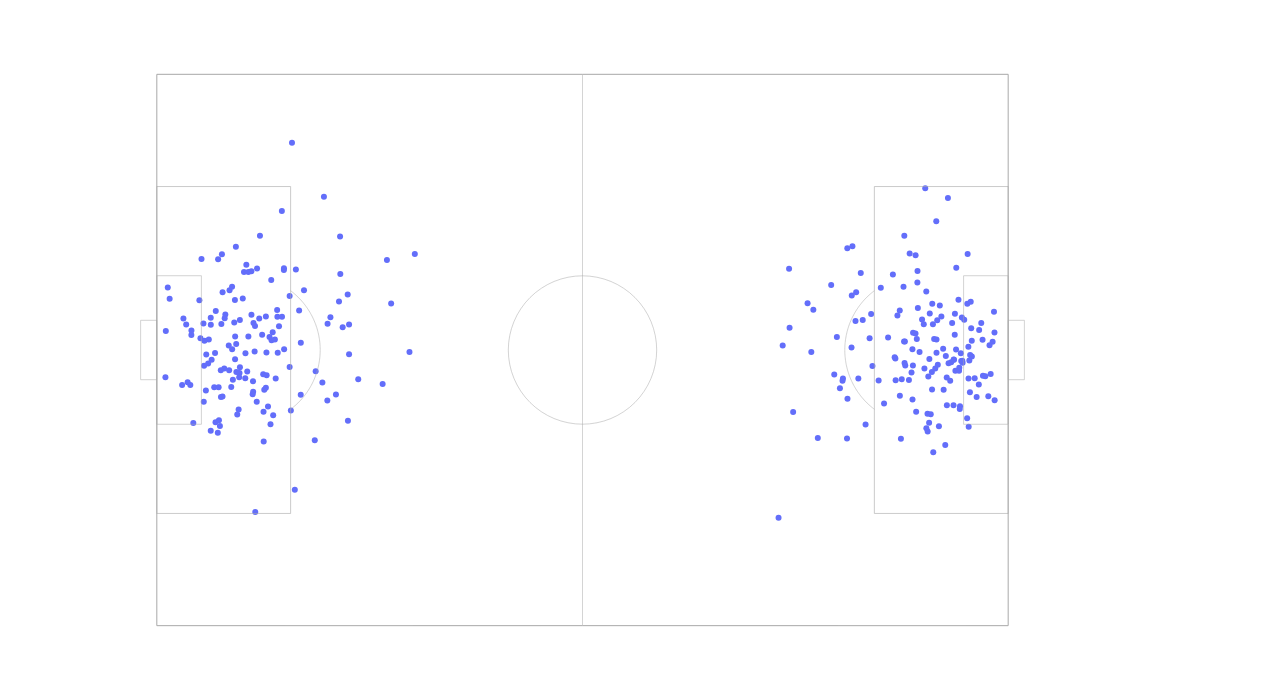

In [61]:
field_layout = soccerfield.get_layout(105, 68)

fig = go.Figure(layout=field_layout)
fig.update_layout(width=1000, height=700, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor='rgba(0,0,0,0)',
                  margin=dict(l=0, r=100, t=0, b=0),
                  xaxis=dict(showgrid=False, zeroline=False), yaxis=dict(showgrid=False, zeroline=False),
                  legend=dict(xanchor="left", x=1, y=0.85,
                              font = dict(family = "Roboto, sans-serif", size = 14))
                  )
fig.add_trace(
    go.Scatter(
        x=shots_df['x'], y=shots_df['y'], mode='markers', showlegend = False,
    ))
fig.show()